INSTALL & IMPORTS

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


DATASET PATH

In [2]:
import zipfile

with zipfile.ZipFile("flowers-recognition.zip", "r") as zip_ref:
    zip_ref.extractall(".")


In [3]:
import os
print(os.listdir("flowers"))


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [4]:
# Path to the directory containing all flower category folders
DATASET_PATH = "flowers"


LOAD DATA INTO TENSORFLOW

In [5]:
import tensorflow as tf

# Image size required by pretrained CNN models like MobileNetV2
IMG_SIZE = (224, 224)

# Number of training samples processed before the model updates weights
BATCH_SIZE = 32


In [6]:
# Load training data (80% of images)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,                        # Ensures reproducibility
    image_size=IMG_SIZE,           # Resize images for CNN input
    batch_size=BATCH_SIZE
)


Found 4317 files belonging to 5 classes.
Using 3454 files for training.


In [7]:
# Load validation data (20% of images)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [8]:
# Retrieve class names and number of output classes
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)

print("Detected classes:", CLASS_NAMES)


Detected classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


NORMALISATION

In [9]:
from tensorflow.keras import layers

# Scale pixel values from [0,255] to [0,1] for faster and stable training
normalization = layers.Rescaling(1./255)

# Apply normalization to training and validation datasets
train_ds = train_ds.map(lambda x, y: (normalization(x), y))
val_ds = val_ds.map(lambda x, y: (normalization(x), y))


In [10]:
# Preload future batches for improved performance
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


DISPLAY SAMPLE IMAGES

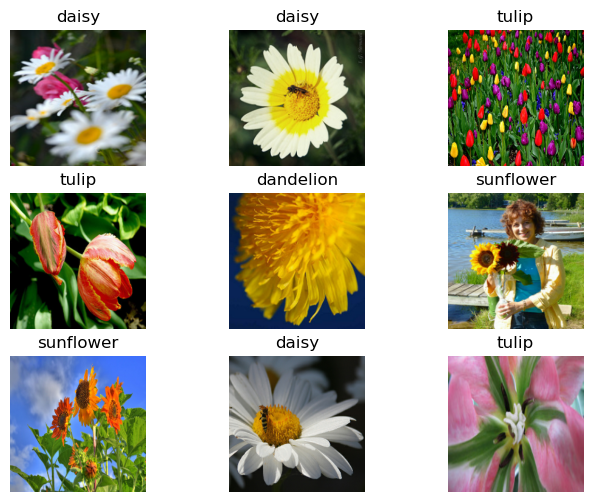

In [11]:
import matplotlib.pyplot as plt

# Visualise a few training images to confirm data loading worked correctly
plt.figure(figsize=(8,6))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        plt.title(CLASS_NAMES[labels[i]])   # Show true label
        plt.axis("off")

plt.show()


Helper: Plot training curves

In [12]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    """
    Utility function to plot training and validation accuracy + loss
    for a given Keras History object.
    """
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,4))

    # Accuracy subplot
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label="Train accuracy")
    plt.plot(epochs, val_acc, label="Val accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss subplot
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label="Train loss")
    plt.plot(epochs, val_loss, label="Val loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.show()


BASELINE CNN (trained from scratch)

In [13]:
from tensorflow.keras import models

# Baseline model: simple CNN trained from scratch on the flower images

baseline_model = models.Sequential([
    
    # Define input shape FIRST using an Input layer
    tf.keras.Input(shape=(224,224,3)),

    # First convolution + pooling block
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Second block
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Third block
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Flatten and fully connected layers
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),  # simple regularisation
    layers.Dense(NUM_CLASSES, activation="softmax")  # output layer
])

# Compile the baseline CNN with standard settings
baseline_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

baseline_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Train baseline model

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 97s 862ms/step - accuracy: 0.3218 - loss: 1.6641 - val_accuracy: 0.5064 - val_loss: 1.0762
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 88s 807ms/step - accuracy: 0.5247 - loss: 1.1454 - val_accuracy: 0.5968 - val_loss: 0.9720
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 90s 831ms/step - accuracy: 0.6239 - loss: 0.9792 - val_accuracy: 0.6107 - val_loss: 0.9282
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 88s 809ms/step - accuracy: 0.6753 - loss: 0.8472 - val_accuracy: 0.6408 - val_loss: 0.9699
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 88s 812ms/step - accuracy: 0.7501 - loss: 0.7018 - val_accuracy: 0.6304 - val_loss: 0.9686
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 95s 876ms/step - accuracy: 0.7888 - loss: 0.5743 - val_accuracy: 0.6582 - val_loss: 1.0023
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 85s 787ms/step - accuracy: 0.8285 - loss: 0.4717 - val_accuracy: 0.6338 - val_loss: 1.1711
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 85s 788ms/step - accuracy: 0.8780 - loss: 0

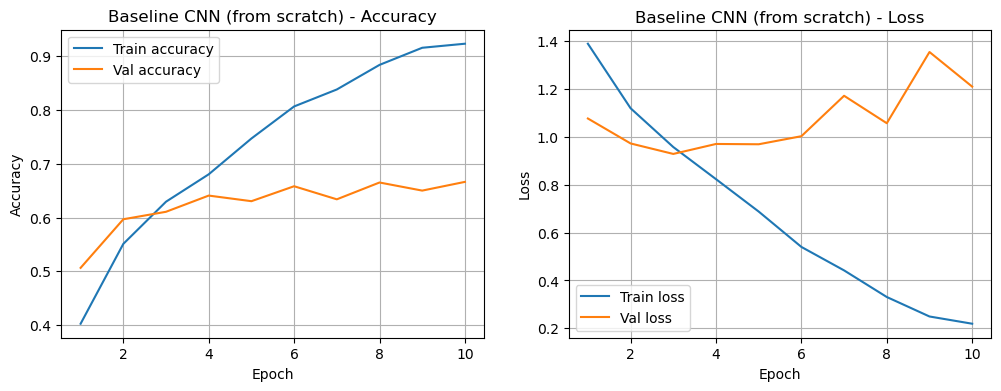

In [14]:
# Train the baseline CNN from scratch (no pretrained weights)

baseline_history = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,     # you can increase later if you want
    verbose=1
)

# Plot training curves for the baseline model
plot_history(baseline_history, "Baseline CNN (from scratch)")


Transfer Learning – MobileNetV2 with frozen base

In [16]:
from tensorflow.keras.applications import MobileNetV2

# Transfer learning model:
#   - Use MobileNetV2 pretrained on ImageNet as a feature extractor
#   - Keep its convolutional base frozen (no weight updates at first)


# Load the pretrained base model WITHOUT the top classifier layers
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)

# Freeze all layers in the base model so only our new head is trained
base_model.trainable = False

# Add our custom classification head on top
inputs = layers.Input(shape=(224,224,3))
x = base_model(inputs, training=False)          # important: keep BN layers in inference mode
x = layers.GlobalAveragePooling2D()(x)          # reduce spatial dimensions
x = layers.Dense(128, activation="relu")(x)     # small fully-connected layer
x = layers.Dropout(0.5)(x)                      # regularisation
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

frozen_model = models.Model(inputs, outputs, name="mobilenetv2_frozen")

# Compile the model: only the top layers have trainable weights
frozen_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

frozen_model.summary()


Model: "mobilenetv2_frozen"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train frozen transfer-learning model

Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 62s 516ms/step - accuracy: 0.6136 - loss: 1.0260 - val_accuracy: 0.8447 - val_loss: 0.4382
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 56s 514ms/step - accuracy: 0.8474 - loss: 0.4477 - val_accuracy: 0.8575 - val_loss: 0.3937
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 52s 479ms/step - accuracy: 0.8841 - loss: 0.3355 - val_accuracy: 0.8714 - val_loss: 0.3415
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 51s 470ms/step - accuracy: 0.8948 - loss: 0.2922 - val_accuracy: 0.8806 - val_loss: 0.3227
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 51s 470ms/step - accuracy: 0.9128 - loss: 0.2449 - val_accuracy: 0.8783 - val_loss: 0.3320


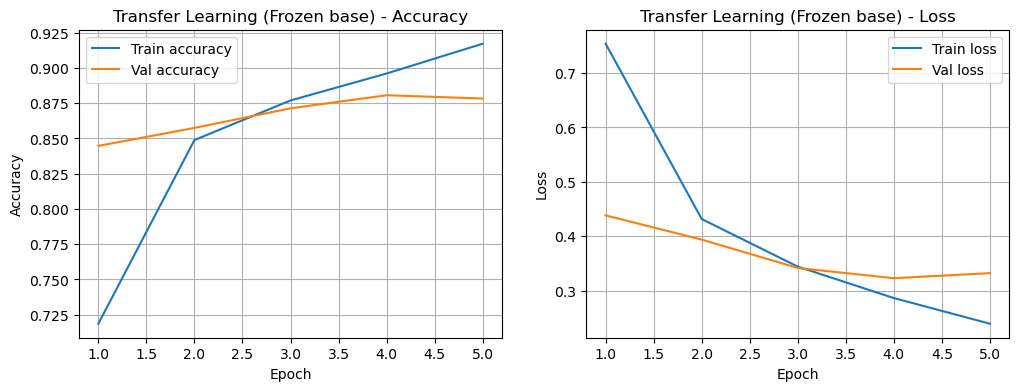

In [17]:
# Train only the new classification head, with the base model frozen.
# This is usually fast and already gives a big jump in accuracy
# compared to training a CNN from scratch.

frozen_history = frozen_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,     # often fewer epochs are enough at this stage
    verbose=1
)

plot_history(frozen_history, "Transfer Learning (Frozen base)")


Fine-tuning – unfreeze top layers of MobileNetV2

In [18]:
# Fine-tuning:
#   - Unfreeze the LAST part of the base model
#   - Train with a very small learning rate so we don't destroy
#     the pretrained ImageNet features.

# Unfreeze the base model
base_model.trainable = True

# unfreeze only the top N layers of the base model
fine_tune_at = 100   # layer index to start fine-tuning from 

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with a lower learning rate for fine-tuning
frozen_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Check how many layers are trainable now
print("Trainable layers:", len([l for l in frozen_model.layers if l.trainable]))


Trainable layers: 6


Train fine-tuned model

Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 92s 753ms/step - accuracy: 0.7929 - loss: 0.5751 - val_accuracy: 0.8714 - val_loss: 0.3516
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 83s 766ms/step - accuracy: 0.8572 - loss: 0.3951 - val_accuracy: 0.8853 - val_loss: 0.3324
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 80s 737ms/step - accuracy: 0.8936 - loss: 0.2981 - val_accuracy: 0.8992 - val_loss: 0.3091
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 78s 719ms/step - accuracy: 0.9079 - loss: 0.2666 - val_accuracy: 0.9038 - val_loss: 0.2898
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 78s 724ms/step - accuracy: 0.9166 - loss: 0.2424 - val_accuracy: 0.9096 - val_loss: 0.2805


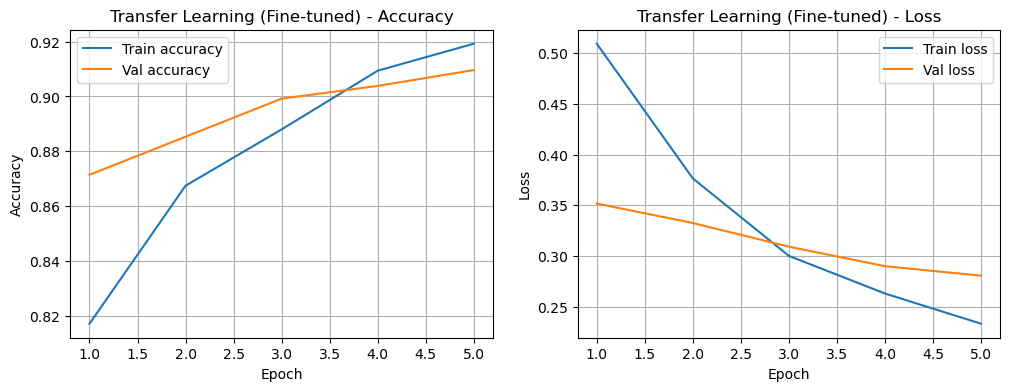

In [19]:
# Continue training: now a small part of the base CNN will also update
fine_tune_history = frozen_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,  
    verbose=1
)

plot_history(fine_tune_history, "Transfer Learning (Fine-tuned)")


Compare models on the validation set

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataset, model_name="Model"):
    """
    Evaluate a trained model on the validation dataset:
      - prints classification report
      - plots confusion matrix
    """
    y_true = []
    y_pred = []

    # Loop over batches and collect predictions + true labels
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print(f"\n=== {model_name} ===")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=CLASS_NAMES,
                yticklabels=CLASS_NAMES)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


Run evaluation for both models


=== Baseline CNN ===
              precision    recall  f1-score   support

       daisy       0.68      0.71      0.70       144
   dandelion       0.74      0.67      0.70       206
        rose       0.50      0.55      0.53       137
   sunflower       0.68      0.83      0.75       172
       tulip       0.69      0.58      0.63       204

    accuracy                           0.67       863
   macro avg       0.66      0.67      0.66       863
weighted avg       0.67      0.67      0.67       863



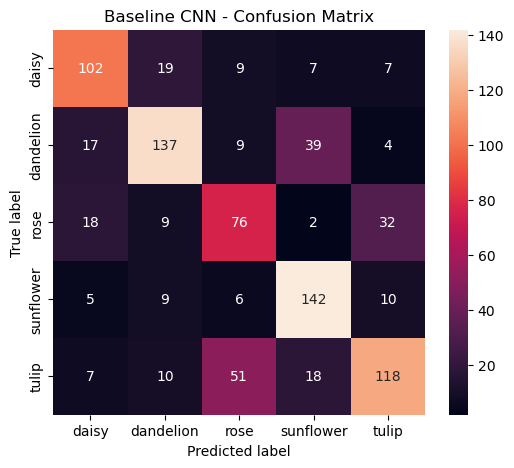


=== Transfer Learning (Fine-tuned MobileNetV2) ===
              precision    recall  f1-score   support

       daisy       0.87      0.92      0.89       144
   dandelion       0.94      0.93      0.94       206
        rose       0.81      0.90      0.85       137
   sunflower       0.95      0.91      0.93       172
       tulip       0.95      0.89      0.92       204

    accuracy                           0.91       863
   macro avg       0.90      0.91      0.91       863
weighted avg       0.91      0.91      0.91       863



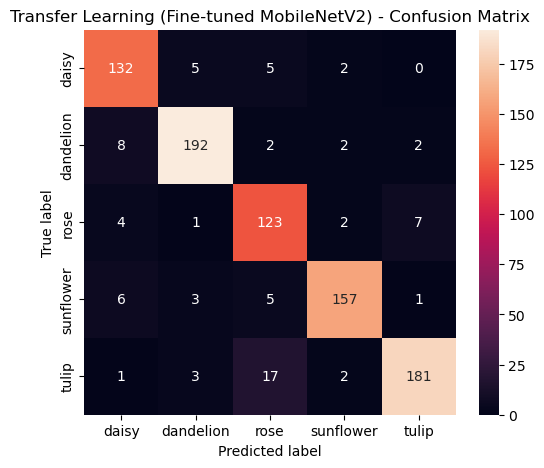

In [21]:
# Baseline CNN (from scratch)
evaluate_model(baseline_model, val_ds, model_name="Baseline CNN")

# Fine-tuned transfer learning model
evaluate_model(frozen_model, val_ds, model_name="Transfer Learning (Fine-tuned MobileNetV2)")


Summary printout

In [22]:
# Quick numeric comparison of validation accuracy
baseline_val_acc = baseline_history.history["val_accuracy"][-1]
frozen_val_acc   = frozen_history.history["val_accuracy"][-1]
fine_val_acc     = fine_tune_history.history["val_accuracy"][-1]

print("Validation accuracy comparison:")
print(f"  Baseline CNN (from scratch):      {baseline_val_acc:.3f}")
print(f"  Transfer learning (frozen base):  {frozen_val_acc:.3f}")
print(f"  Transfer learning (fine-tuned):   {fine_val_acc:.3f}")


Validation accuracy comparison:
  Baseline CNN (from scratch):      0.666
  Transfer learning (frozen base):  0.878
  Transfer learning (fine-tuned):   0.910


Final Prediction Visualization

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def show_predictions(model, dataset, class_names, n=6):
    """
    Displays images with predicted and ground truth labels.
    
    Green title = correct prediction
    Red title   = wrong prediction
    """
    # Take one batch from validation dataset
    images, labels = next(iter(dataset))

    # Generate predictions
    predictions = model.predict(images)

    # Plot result images
    plt.figure(figsize=(15, 5))

    for i in range(n):
        true_label = class_names[labels[i]]
        pred_label = class_names[np.argmax(predictions[i])]

        # Set colour based on correctness
        color = "green" if pred_label == true_label else "red"

        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        plt.title(f"Pred: {pred_label}\nGT: {true_label}", color=color)
        plt.axis("off")

    plt.show()


Final Outputs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


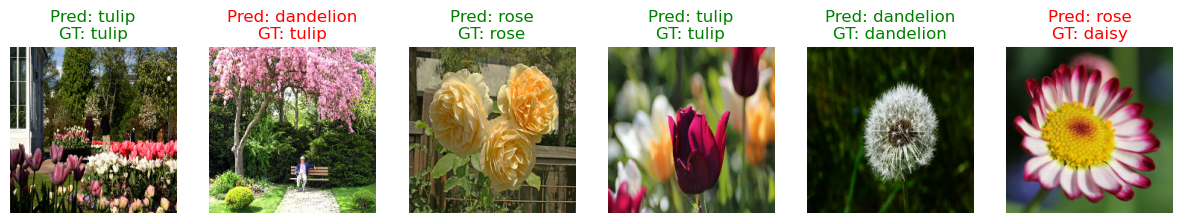

In [27]:
show_predictions(baseline_model, val_ds, CLASS_NAMES, n=6)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


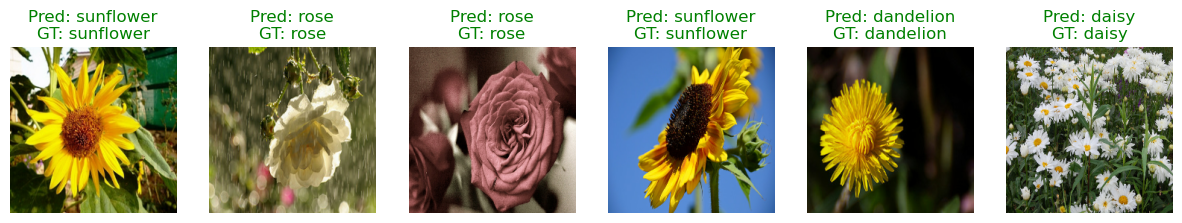

In [28]:
show_predictions(frozen_model, val_ds, CLASS_NAMES, n=6)
